In [1012]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.stattools import durbin_watson
import re
import os
import seaborn as sns
from matplotlib import cm, colors
import matplotlib.ticker as ticker

In [1013]:
PATH = os.getcwd()
TEST_FOLDER = 'test-result'
REGGRESSION_FOLDER = 'regressions'
PARAMETRIC_FOLDER = 'parametric'
DURBIN_WATSON = 'durbin-watson'
ACENTUACION_FOLDER = 'Acentuacion'
CADENCIA_FOLDER = 'Cadencia'
INTELIGIBILIDAD_FOLDER = 'Inteligibilidad'
NATURALIDAD_FOLDER = 'Naturalidad'
PRONUNCIACION_FOLDER = 'Pronunciacion'
MALE_FOLDER = 'masculino'
FEMALE_FOLDER = 'femenino'

In [1014]:
# Diccionario para guardar los p-value
dicc_p_value = {
    'subjetive_parameter':[],
    'ZCR':[],
    'RMS':[],
    'f0':[],
    'selected_features':[],
    'shapiro_wilk_test':[],
    'genero':[] 
}

In [1015]:
# Inicializamos el diccionario
dicc_dw = {
    "Dublin-Watson Test": [],
    "Parametro subjetivo": [],
    "Genero":[]
}

In [1016]:
# Voy a limpiar los graficos que hay en las carpetas

list_files = os.listdir(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER))

list_folder = []
for folder in list_files:
    if not folder.endswith('.xlsx'):
        list_folder.append(folder)
        
SUBFOLDER_GENDER = ['masculino', 'femenino']

for folder in list_folder:
    for gender in SUBFOLDER_GENDER:
        os.chdir(os.path.join(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, folder, gender)))
        all_files = os.listdir()
        if len(all_files) == 0:
            continue
        for f in all_files:
            os.remove(f)

os.chdir(PATH)

In [1017]:
list_folder

['Acentuacion', 'Cadencia', 'Inteligibilidad', 'Naturalidad', 'Pronunciacion']

In [1018]:
merged_df = pd.read_csv(r'aux_file\data_regression.csv')

In [1019]:
obj_params = pd.read_excel('voces_test_rms.ods')

In [1020]:
obj_params.head()

,zero_crossing_rate,rms,mfcc,pitch,genero,file
0,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino,hyacinthe-lovo-v3.wav
1,0.093035,-27.0,[-424.61664 138.61742 -14.495688 3...,101.312090,femenino,lola-murf.wav
2,0.093043,-22.5,[-3.71418152e+02 1.31561859e+02 -1.60284328e+...,76.492752,masculino,neural2B-GCP.wav
3,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino,alonso-naturalreader.wav
4,0.105458,-21.5,[-3.5115176e+02 1.1943483e+02 -1.9279911e+01 ...,69.045778,masculino,antonio-murf.wav


In [1021]:
df_union = pd.merge(
    merged_df,
    obj_params,
    how='left',
    left_on='filename',
    right_on='file'
).drop(columns=['file'])

In [1022]:
df_union.rename(
    columns={
        'zero_crossing_rate': 'zcr',
        'pitch': 'f0'
    },
    inplace=True
)

In [1023]:
df_union.head()

,ID,filename,Inteligibilidad,Pronunciacion,Acentuacion,Naturalidad,Cadencia,zcr,rms,mfcc,f0,genero
0,1,alonso-naturalreader.wav,4.867647,4.621212,4.426471,3.250000,3.823529,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino
1,2,hyacinthe-lovo-v3.wav,4.970588,4.692308,4.602941,4.308824,4.250000,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino
2,3,neural2C-pitchmodified-speedmodified.wav,4.515625,3.962963,2.852941,1.779412,1.720588,0.251626,-25.0,[-4.4141333e+02 8.9362648e+01 -1.2164741e+01 ...,98.468505,masculino
3,4,francisca-lovo-v2.wav,4.746269,4.276923,4.294118,3.220588,3.823529,0.137822,-26.1,[-454.8679 72.41395 -14.8625145 45.9...,116.353345,femenino
4,5,antoni-evenlabs-linguistico-v2.wav,4.681818,4.064516,3.220588,1.897059,1.779412,0.239188,-24.0,[-406.19888 84.30505 -12.89493 18.8...,78.968152,masculino


## SelectorFeature

In [1024]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.utils import check_random_state
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
from scipy import stats

In [1025]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """Un envoltorio para hacer que los modelos de regresión de statsmodels sean compatibles con la API de scikit-learn"""
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.model = None

    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model = self.model_class(y, X)
        self.results = self.model.fit()
        return self.results

    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results.predict(X)

In [1026]:
# Función para formatear los números con coma como separador decimal
def format_decimal(x, pos):
    return '{:.2f}'.format(x).replace('.', ',')

### Inteligibilidad

In [1027]:
df_inteligibilidad = df_union.loc[:, ['Inteligibilidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [1028]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'masculino'

df_inteligibilidad_male = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [1029]:
# Cargamos los datos
X = np.array(df_inteligibilidad_male.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_male.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
  
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    
dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Inteligibilidad')
dicc_dw["Genero"].append('masculino')


Coeficiente de determinación R^2: 0.5392
Shapiro-Wilk p-valor: 0.5369030833244324
Durbin-Watson: 1.7195668096374823
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0156

p-valor global: 0.01559663427711739
Ecuación: 5.05 - 2.32*ZCR

Característica ZCR: p-valor = 0.1397
Característica RMS: p-valor = 0.4971
Característica f0: p-valor = 0.6041


In [1030]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1031]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2,32 * ZCR$^{*}$ + 5,05 - R$^2$ = 0,539


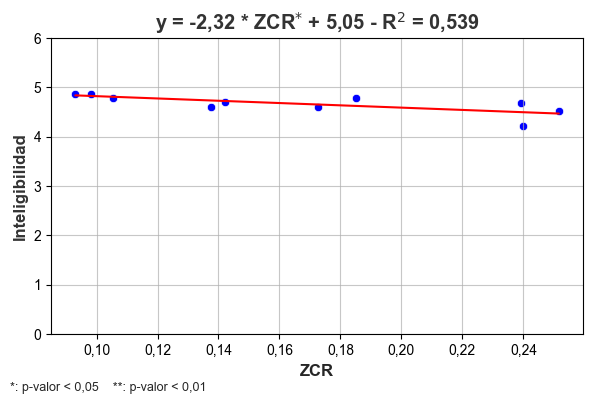

In [1032]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresiones_inteligibilidad_male.png'))
    plt.show()


In [1033]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))
    
    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.png')
    )


    fig.show()


#### Femenino

In [1034]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'femenino'

df_inteligibilidad_female = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [1035]:
# Cargamos los datos
X = np.array(df_inteligibilidad_female.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_female.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Inteligibilidad')
dicc_dw["Genero"].append('femenino')


Coeficiente de determinación R^2: 0.8008
Shapiro-Wilk p-valor: 0.5264934301376343
Durbin-Watson: 1.2089757184238168
Características seleccionadas: (0, 2)
Característica Seleccionada ZCR: p-valor = 0.0015
Característica Seleccionada f0: p-valor = 0.0386

p-valor global: 0.003527343960223371
Ecuación: 5.94 - 2.46*ZCR - 0.01*RMS

Característica ZCR: p-valor = 0.0324
Característica RMS: p-valor = 0.6260
Característica f0: p-valor = 0.0539


In [1036]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1037]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2,26 * ZCR$^{**}$ + 5,09
y = -0,01 * $f_{0}$$^{*}$ + 5,29


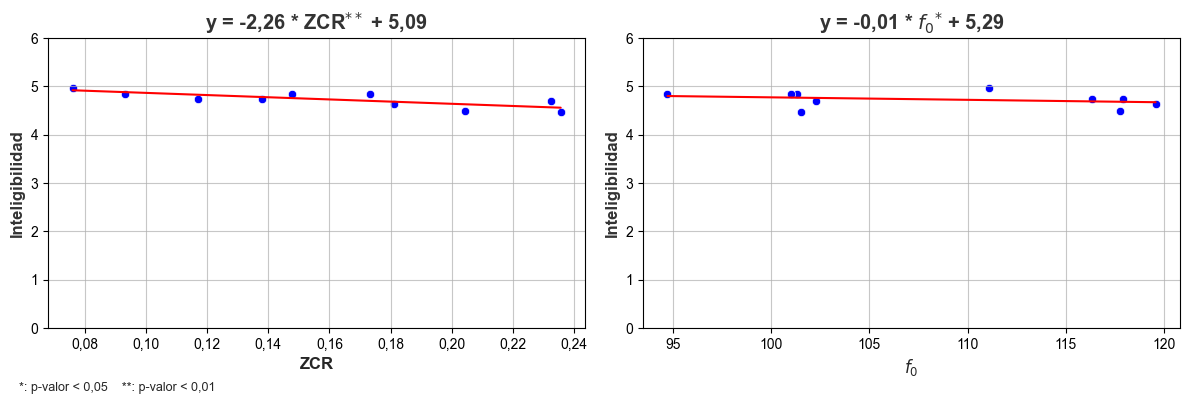

In [1038]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(
        os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_inteligibilidad_female.png')
    )
    plt.show()


In [1039]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))


    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
     
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))
    
    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.png')
    )


    fig.show()


### Pronunciacion

In [1040]:
df_pronunciacion = df_union.loc[:, ['Pronunciacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [1041]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'masculino'

df_pronunciacion_male = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [1042]:
# Cargamos los datos
X = np.array(df_pronunciacion_male.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_male.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Pronunciación')
dicc_dw["Genero"].append('masculino')


Coeficiente de determinación R^2: 0.7798
Shapiro-Wilk p-valor: 0.10431306064128876
Durbin-Watson: 2.652854131410712
Características seleccionadas: (0, 1)
Característica Seleccionada ZCR: p-valor = 0.0028
Característica Seleccionada RMS: p-valor = 0.0459

p-valor global: 0.005011690778112325
Ecuación: 2.51 - 5.47*ZCR - 0.12*RMS

Característica ZCR: p-valor = 0.0077
Característica RMS: p-valor = 0.0483
Característica f0: p-valor = 0.3416


In [1043]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1044]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -3,07 * ZCR$^{**}$ + 4,81
y = 0,06 * RMS$^{*}$ + 5,69


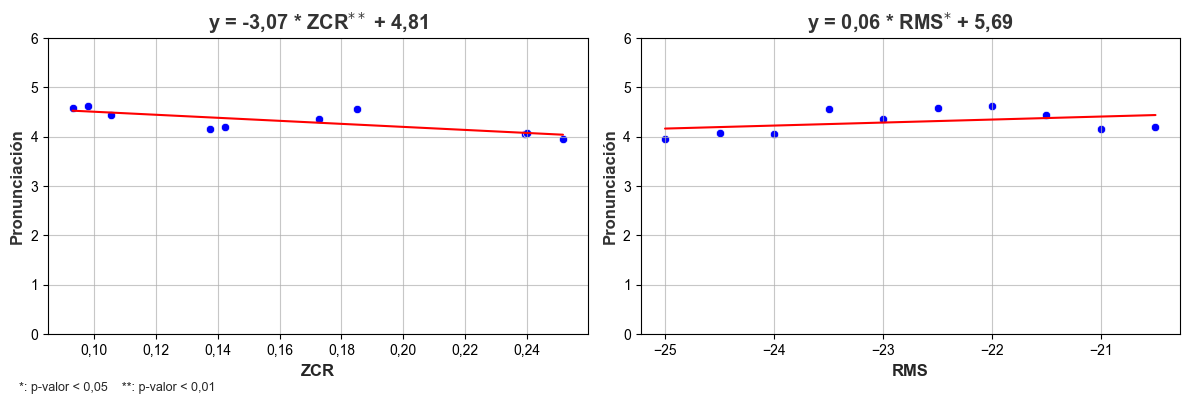

In [1045]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
    
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresiones_pronunciacion_male.png'))
    plt.show()


In [1046]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))
    
    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [1047]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'femenino'

df_pronunciacion_female = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [1048]:
# Cargamos los datos
X = np.array(df_pronunciacion_female.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_female.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Pronunciación')
dicc_dw["Genero"].append('femenino')


Coeficiente de determinación R^2: 0.6758
Shapiro-Wilk p-valor: 0.019548965618014336
Durbin-Watson: 1.0443096256248927
Características seleccionadas: (0, 2)
Característica Seleccionada ZCR: p-valor = 0.0120
Característica Seleccionada f0: p-valor = 0.0524

p-valor global: 0.019407839254210572
Ecuación: 6.13 - 2.83*ZCR - 0.01*RMS

Característica ZCR: p-valor = 0.1217
Característica RMS: p-valor = 0.7014
Característica f0: p-valor = 0.0722


In [1049]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1050]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2,51 * ZCR$^{*}$ + 4,79
y = -0,01 * $f_{0}$ + 5,37


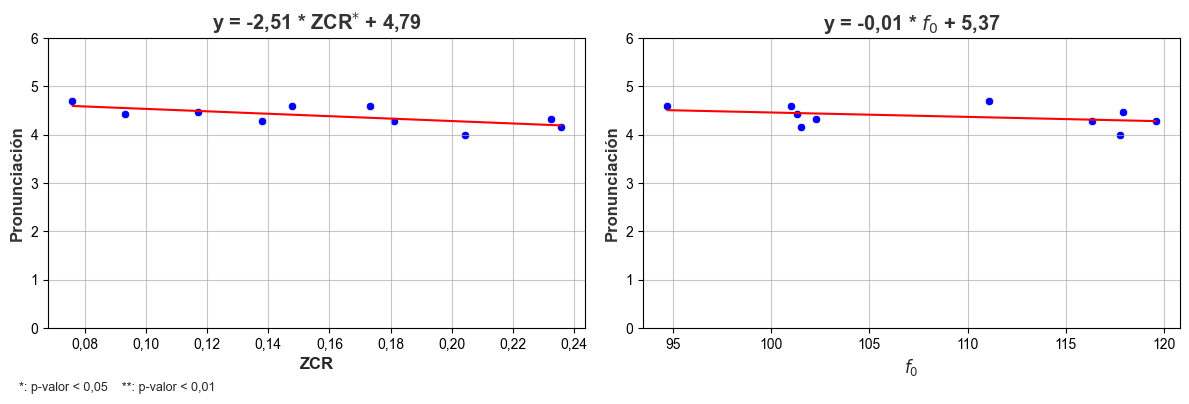

In [1051]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresiones_pronunciacion_female.png'))
    plt.show()


In [1052]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))
    
    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.png')
    )

    fig.show()


### Acentuacion

In [1053]:
df_acentuacion = df_union.loc[:, ['Acentuacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [1054]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'masculino'

df_acentuacion_male = df_acentuacion[mask_gender].drop(columns=['genero'])

In [1055]:
# Cargamos los datos
X = np.array(df_acentuacion_male.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_male.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Acentuación')
dicc_dw["Genero"].append('masculino')


Coeficiente de determinación R^2: 0.6890
Shapiro-Wilk p-valor: 0.8480933904647827
Durbin-Watson: 2.637199390357284
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0030

p-valor global: 0.002955902156710493
Ecuación: 5.08 - 8.08*ZCR

Característica ZCR: p-valor = 0.0168
Característica RMS: p-valor = 0.1353
Característica f0: p-valor = 0.3779


In [1056]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1057]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -8,08 * ZCR$^{**}$ + 5,08 - R$^2$ = 0,689


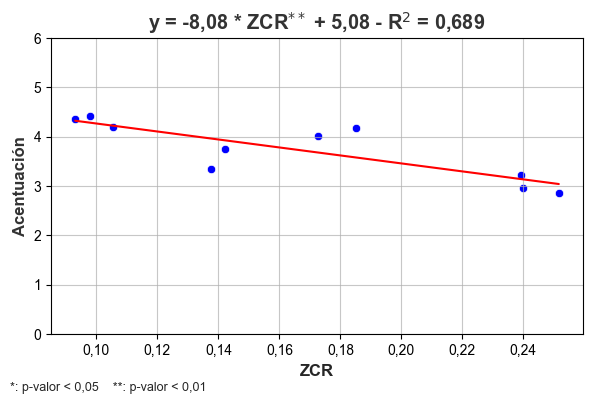

In [1058]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresiones_acentuacion_male.png'))
    plt.show()


In [1059]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Acentuación', zaxis=dict(range=[0, 6])))
    
    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [1060]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'femenino'

df_acentuacion_female = df_acentuacion[mask_gender].drop(columns=['genero'])

In [1061]:
# Cargamos los datos
X = np.array(df_acentuacion_female.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_female.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Acentuación')
dicc_dw["Genero"].append('femenino')


Coeficiente de determinación R^2: 0.5348
Shapiro-Wilk p-valor: 0.9564486742019653
Durbin-Watson: 1.902658671445973
Características seleccionadas: (1, 2)
Característica Seleccionada RMS: p-valor = 0.0521
Característica Seleccionada f0: p-valor = 0.1067

p-valor global: 0.06867595963202278
Ecuación: 12.44 + 0.20*ZCR - 0.03*RMS

Característica ZCR: p-valor = 0.4835
Característica RMS: p-valor = 0.3797
Característica f0: p-valor = 0.1105


In [1062]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1063]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = 0,18 * RMS + 9,16
y = -0,02 * $f_{0}$ + 6,52


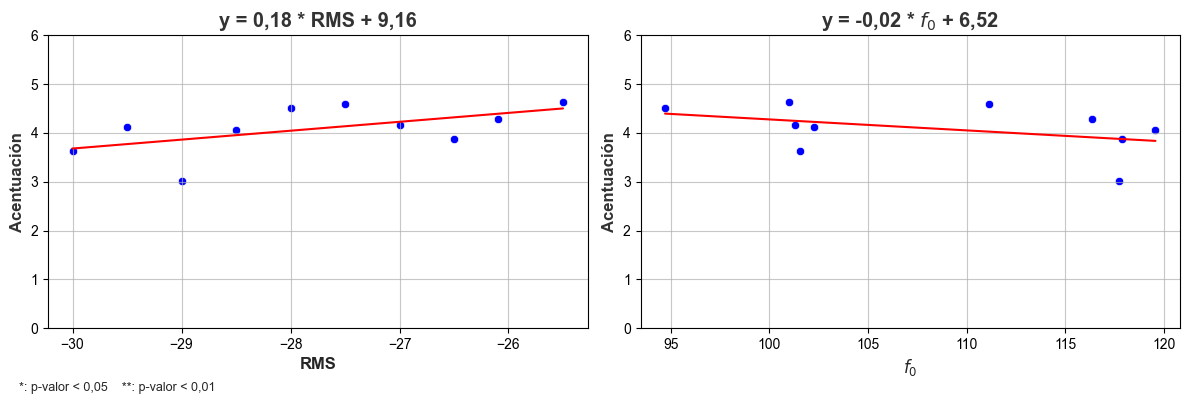

In [1064]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresiones_acentuacion_female.png'))
    plt.show()


In [1065]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Acentuación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))
    
    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.png')
    )

    fig.show()


### Naturalidad

In [1066]:
df_naturalidad = df_union.loc[:, ['Naturalidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [1067]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'masculino'

df_naturalidad_male = df_naturalidad[mask_gender].drop(columns=['genero'])

In [1068]:
# Cargamos los datos
X = np.array(df_naturalidad_male.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_male.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Naturalidad')
dicc_dw["Genero"].append('masculino')


Coeficiente de determinación R^2: 0.8144
Shapiro-Wilk p-valor: 0.9401729702949524
Durbin-Watson: 2.1105953426825907
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0004

p-valor global: 0.0003514629613687443
Ecuación: 4.66 - 11.44*ZCR

Característica ZCR: p-valor = 0.0144
Característica RMS: p-valor = 0.9226
Característica f0: p-valor = 0.7219


In [1069]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1070]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared

    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -11,44 * ZCR$^{**}$ + 4,66 - R$^2$ = 0,814


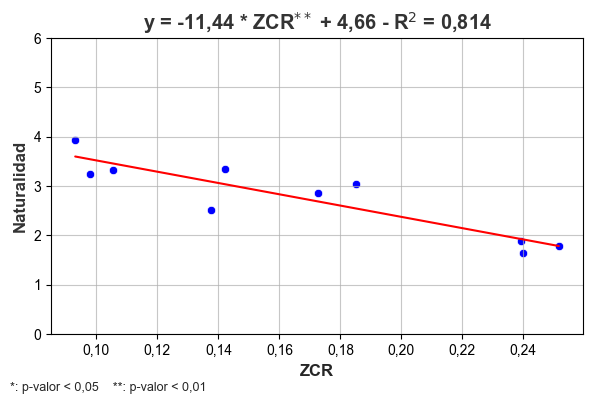

In [1071]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresiones_naturalidad_male.png'))
    plt.show()


In [1072]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.html')
    )
    
    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [1073]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'femenino'

df_naturalidad_female = df_naturalidad[mask_gender].drop(columns=['genero'])

In [1074]:
# Cargamos los datos
X = np.array(df_naturalidad_female.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_female.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Naturalidad')
dicc_dw["Genero"].append('femenino')


Coeficiente de determinación R^2: 0.6409
Shapiro-Wilk p-valor: 0.026250893250107765
Durbin-Watson: 1.402493870586606
Características seleccionadas: (1, 2)
Característica Seleccionada RMS: p-valor = 0.0141
Característica Seleccionada f0: p-valor = 0.1263

p-valor global: 0.02775608961568071
Ecuación: 17.29 + 0.38*ZCR - 0.03*RMS

Característica ZCR: p-valor = 0.1165
Característica RMS: p-valor = 0.3008
Característica f0: p-valor = 0.0680


In [1075]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1076]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = 0,36 * RMS$^{*}$ + 13,09
y = -0,03 * $f_{0}$ + 6,07


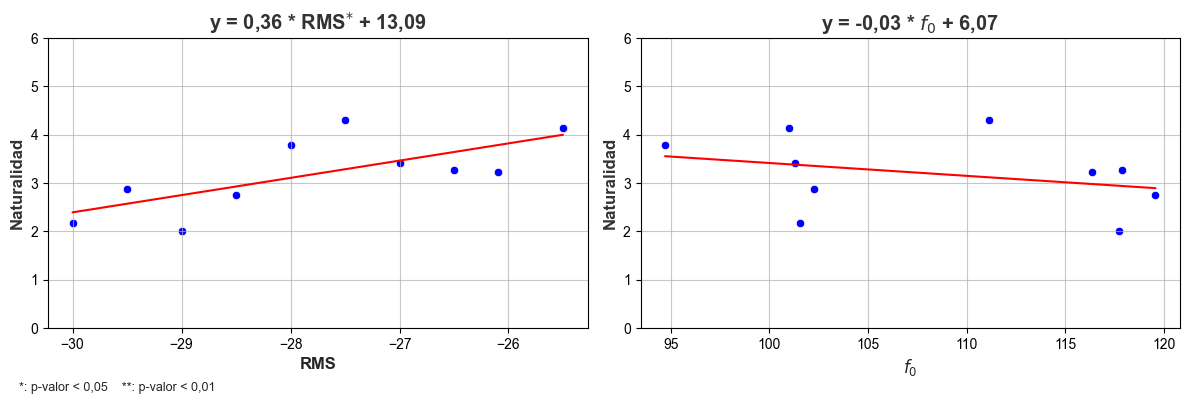

In [1077]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_naturalidad_female.png'))
    plt.show()


In [1078]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.png')
    )


    fig.show()


### Cadencia

In [1079]:
df_cadencia = df_union.loc[:, ['Cadencia', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [1080]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'masculino'

df_cadencia_male = df_cadencia[mask_gender].drop(columns=['genero'])

In [1081]:
# Cargamos los datos
X = np.array(df_cadencia_male.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_male.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')


dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Cadencia')
dicc_dw["Genero"].append('masculino')


Coeficiente de determinación R^2: 0.8347
Shapiro-Wilk p-valor: 0.6572168469429016
Durbin-Watson: 2.352290246781225
Características seleccionadas: (0,)
Característica Seleccionada ZCR: p-valor = 0.0002

p-valor global: 0.0002194107813633637
Ecuación: 5.10 - 13.50*ZCR

Característica ZCR: p-valor = 0.0036
Característica RMS: p-valor = 0.2866
Característica f0: p-valor = 0.8908


In [1082]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1083]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -13,5 * ZCR$^{**}$ + 5,1 - R$^2$ = 0,835


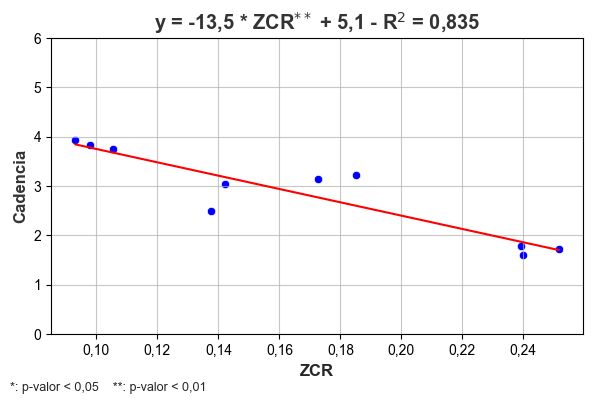

In [1084]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresiones_cadencia_male.png'))
    plt.show()


In [1085]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))
    
    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[75, 80, 85, 90, 95])))

    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.png')
    )

    fig.show()


#### Femenino

In [1086]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'femenino'

df_cadencia_female = df_cadencia[mask_gender].drop(columns=['genero'])

In [1087]:
# Cargamos los datos
X = np.array(df_cadencia_female.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_female.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Lógica para rellenar las características no seleccionadas
count_features = set(selected_features)
total_features = set([0,1,2])
missing_features = total_features - count_features

for missing_feature in missing_features:
    if missing_feature == 0:
        dicc_p_value['ZCR'].append(np.nan)
    elif missing_feature == 1:
        dicc_p_value['RMS'].append(np.nan)
    else:
        dicc_p_value['f0'].append(np.nan)

regr_multivar_fit = regr_multivar.fit(X[:, selected_features], y)

# Obtenemos el R^2 del modelo
r_squared_value = regr_multivar_fit.rsquared

print(f'Coeficiente de determinación R^2: {r_squared_value:.4f}')

# Obtenemos los residuos del modelo
residuals = y - regr_multivar.predict(X[:, selected_features])

# Realizamos la prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)

# Imprimimos el resultado de la prueba
print('Shapiro-Wilk p-valor:', shapiro_test.pvalue)

# Realizamos el test de Durbin-Watson
dw_test = durbin_watson(residuals)

# Imprimimos el resultado del test
print('Durbin-Watson:', dw_test)

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(selected_features, regr_multivar_fit.pvalues[1:]):
    
    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
        
    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)
    
    print(f'Característica Seleccionada {feature}: p-valor = {pvalue:.4f}')

print()

# Imprimimos el p-valor global
print('p-valor global:', regr_multivar_fit.f_pvalue)

features = {
    1: 'ZCR',
    2: 'RMS',
    3: 'f0'
}

# Imprimimos la ecuación resultante
equation = "Ecuación: "
for i, coef in enumerate(regr_multivar_fit.params):
    if i == 0:
        equation += f"{coef:.2f}"
    else:
        if coef < 0:
            equation += f" - {-coef:.2f}*{features[i]}"
        else:
            equation += f" + {coef:.2f}*{features[i]}"
print(equation)

print()
# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))
dicc_p_value['shapiro_wilk_test'].append(shapiro_test.pvalue)

# Almacenamos los resultados en el diccionario
dicc_dw["Dublin-Watson Test"].append(dw_test)
dicc_dw["Parametro subjetivo"].append('Cadencia')
dicc_dw["Genero"].append('femenino')


Coeficiente de determinación R^2: 0.8850
Shapiro-Wilk p-valor: 0.8104830980300903
Durbin-Watson: 1.1912281124725277
Características seleccionadas: (0, 1, 2)
Característica Seleccionada ZCR: p-valor = 0.0800
Característica Seleccionada RMS: p-valor = 0.0495
Característica Seleccionada f0: p-valor = 0.0197

p-valor global: 0.0031825075013412383
Ecuación: 16.18 - 6.39*ZCR + 0.27*RMS - 0.04*f0

Característica ZCR: p-valor = 0.0800
Característica RMS: p-valor = 0.0495
Característica f0: p-valor = 0.0197


In [1088]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [1089]:
list_equ = []

for idx, (key, model) in enumerate(dicc_model.items()):
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    r_squared = model.rsquared
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Verificamos el valor de p y agregamos el superíndice correspondiente
    if p_values[idx] < 0.01:
        label += '$^{**}$'
    elif p_values[idx] < 0.05:
        label += '$^{*}$'

    if len(dicc_model) == 1:
        # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
        equation = f'y = {w.round(2)} * {label} + {b.round(2)} - R$^2$ = {r_squared:.3f}'
    else:
        equation = f'y = {w.round(2)} * {label} + {b.round(2)}'

    equation = equation.replace('.', ',')
    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -10,88 * ZCR + 5,13
y = 0,42 * RMS$^{*}$ + 15,17
y = -0,03 * $f_{0}$$^{*}$ + 6,38


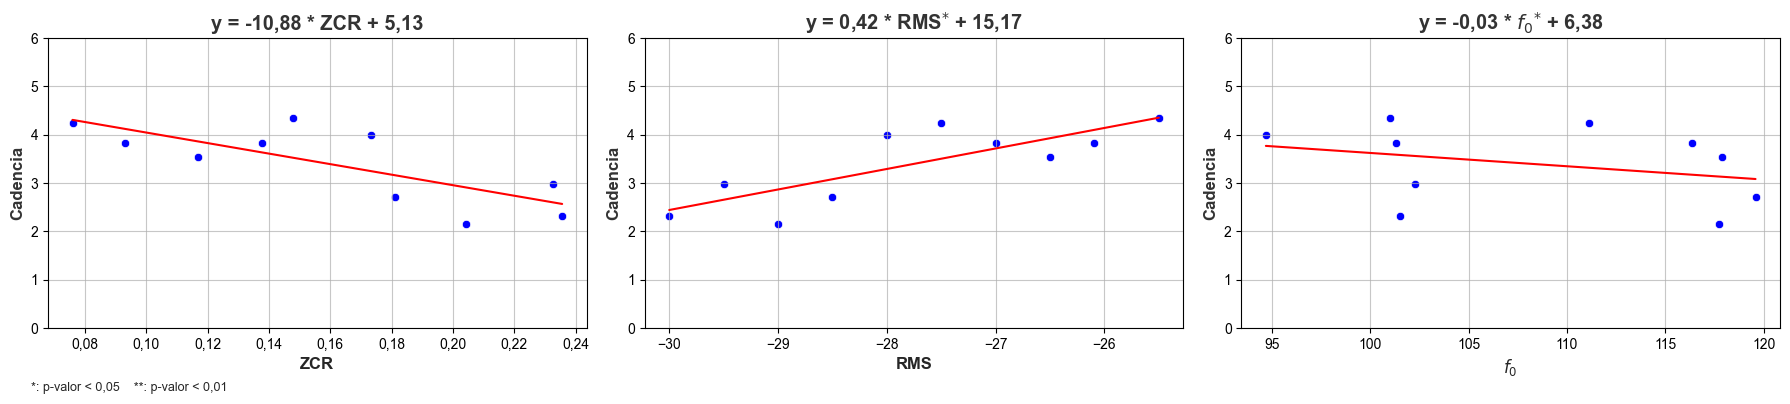

In [1090]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)
        
        # Verificar si los valores en el eje x son menores que 1
        if np.any(np.abs(X[:, dicc_names_features[key]]) < 1):
            # Crear el formateador
            formatter = ticker.FuncFormatter(format_decimal)

            # Usar el formateador en el eje x de tus gráficos
            ax_i.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.figtext(0.02, 0.01, '*: p-valor < 0,05    **: p-valor < 0,01', fontsize=9)
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresiones_cadencia_female.png'))
    plt.show()


In [1091]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    axis_name_list = []
    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        feature_name = key.replace("_model", "").upper()
        feature_name_axis = feature_name
        if feature_name == 'F0':
            feature_name = '<i>f₀</i>'
            feature_name_axis = 'f₀'
        axis_name_list.append(feature_name_axis)
        if regr_multivar_fit.pvalues[1:][i] < 0.01:
            label = '<sup>**</sup>'
        elif regr_multivar_fit.pvalues[1:][i] < 0.05:
            label = '<sup>*</sup>'
        else:
            label = ''
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {feature_name} {label}'
        
    equation += f' - R² = {r_squared_value:.3f}'
    equation = equation.replace('.', ',')
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Verificar si los valores en el eje x son menores que 1
    if np.any(np.abs(X_selected[:, 0]) < 1):
        # Calcular los valores de los ticks
        xaxis_tickvals = np.linspace(np.min(X_selected[:, 0]), np.max(X_selected[:, 0]), 6)[1:5]

        # Convertir los valores de los ticks a strings y reemplazar los puntos por comas
        xaxis_ticktext = [f'{val:.2f}'.replace('.', ',') for val in xaxis_tickvals]
    else:
        # Si los valores en el eje x son mayores o iguales a 1, usar el formato por defecto
        xaxis_tickvals = None
        xaxis_ticktext = None
        
    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis=dict(title=axis_name_list[0], tickvals=xaxis_tickvals, ticktext=xaxis_ticktext), yaxis_title=axis_name_list[1], zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115, 120])))
    
    # Agrega la anotación al final
    fig.add_annotation(
        x=0.07,
        y=-0.15,
        xref="paper",
        yref="paper",
        text="*: p-valor < 0,05    **: p-valor < 0,01",
        showarrow=False,
        font=dict(
            size=13
        )
    )

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.html')
    )

    fig.write_image(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.png')
    )

    fig.show()

## Output p-values regressions

In [1092]:
df_output_p_value_regression = pd.DataFrame(dicc_p_value)

In [1093]:
# Crea un diccionario para mapear los valores
map_dict = {0: 'ZCR', 1: 'RMS', 2: 'F0'}

df_output_p_value_regression['selected_features'] = df_output_p_value_regression['selected_features'].apply(lambda x: [map_dict[val] for val in x])

df_output_p_value_regression.fillna('-', inplace=True)

C:\Users\lnard\AppData\Local\Temp\ipykernel_3968\138939346.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [1094]:
df_output_p_value_regression['shapiro_wilk_test_result'] = df_output_p_value_regression.shapiro_wilk_test.apply(
    lambda x: 'No hay evidencia suficiente para afirmar que los residuos no se distribuyen normalmente' if x > 0.05
    else 'Hay evidencia suficiente para afirmar que los residuos no se distribuyen normalmente'
)

In [1095]:
df_output_p_value_regression

,subjetive_parameter,ZCR,RMS,f0,selected_features,shapiro_wilk_test,genero,shapiro_wilk_test_result
0,Inteligibilidad,0.015597,-,-,[ZCR],0.536903,masculino,No hay evidencia suficiente para afirmar que l...
1,Inteligibilidad,0.001549,-,0.03856,"[ZCR, F0]",0.526493,femenino,No hay evidencia suficiente para afirmar que l...
2,Pronunciación,0.002814,0.045937,-,"[ZCR, RMS]",0.104313,masculino,No hay evidencia suficiente para afirmar que l...
3,Pronunciación,0.012001,-,0.05237,"[ZCR, F0]",0.019549,femenino,Hay evidencia suficiente para afirmar que los ...
4,Acentuación,0.002956,-,-,[ZCR],0.848093,masculino,No hay evidencia suficiente para afirmar que l...
5,Acentuación,-,0.052149,0.10671,"[RMS, F0]",0.956449,femenino,No hay evidencia suficiente para afirmar que l...
6,Naturalidad,0.000351,-,-,[ZCR],0.940173,masculino,No hay evidencia suficiente para afirmar que l...
7,Naturalidad,-,0.014109,0.12627,"[RMS, F0]",0.026251,femenino,Hay evidencia suficiente para afirmar que los ...
8,Cadencia,0.000219,-,-,[ZCR],0.657217,masculino,No hay evidencia suficiente para afirmar que l...
9,Cadencia,0.080017,0.049479,0.019715,"[ZCR, RMS, F0]",0.810483,femenino,No hay evidencia suficiente para afirmar que l...


In [1096]:
df_output_p_value_regression.to_excel(
    os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, 'output_p_values_parametric_regressions.xlsx'),
    index=False
)

## Output Test Durbin-Watson

In [1097]:
# Convertimos el diccionario a DataFrame
df_durbin_watson = pd.DataFrame(dicc_dw)

# Creamos una nueva columna 'Resultado' basada en los valores del test de Durbin-Watson
df_durbin_watson['Resultado'] = pd.cut(
    df_durbin_watson['Dublin-Watson Test'],
    bins=[0, 1.5, 2.5, 4],
    labels=['Existe autocorrelación grave positiva',
            'Existe autocorrelación pero no es un problema',
            'Existe autocorrelación grave negativa'],
    include_lowest=True
)

# Convertimos la columna 'Resultado' a una cadena
df_durbin_watson['Resultado'] = df_durbin_watson['Resultado'].astype(str)

# Si el valor es exactamente 2, decimos que no hay autocorrelación
df_durbin_watson.loc[df_durbin_watson['Dublin-Watson Test'] == 2, 'Resultado'] = 'No hay autocorrelación'

df_durbin_watson = df_durbin_watson.rename(
    columns={
        'Dublin-Watson Test': 'Durbin-Watson',
        'Parametro subjetivo': 'Parámetro subjetivo',
        'Genero': 'Género'
    }
)

df_durbin_watson = df_durbin_watson.loc[:, ['Parámetro subjetivo', 'Género', 'Durbin-Watson', 'Resultado']]

In [1098]:
df_durbin_watson

,Parámetro subjetivo,Género,Durbin-Watson,Resultado
0,Inteligibilidad,masculino,1.719567,Existe autocorrelación pero no es un problema
1,Inteligibilidad,femenino,1.208976,Existe autocorrelación grave positiva
2,Pronunciación,masculino,2.652854,Existe autocorrelación grave negativa
3,Pronunciación,femenino,1.044310,Existe autocorrelación grave positiva
4,Acentuación,masculino,2.637199,Existe autocorrelación grave negativa
5,Acentuación,femenino,1.902659,Existe autocorrelación pero no es un problema
6,Naturalidad,masculino,2.110595,Existe autocorrelación pero no es un problema
7,Naturalidad,femenino,1.402494,Existe autocorrelación grave positiva
8,Cadencia,masculino,2.352290,Existe autocorrelación pero no es un problema
9,Cadencia,femenino,1.191228,Existe autocorrelación grave positiva


In [1099]:
df_durbin_watson.to_excel(
    os.path.join(PATH, TEST_FOLDER, DURBIN_WATSON, 'output_durbin_watson_test.xlsx'),
    index=False
)